##Step 1: Setup Google Colab & Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
import pandas as pd
file_path = "/content/drive/MyDrive/Colab Notebooks/House/house_prices.csv"
df = pd.read_csv(file_path)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Index,Title,Description,Amount(in rupees),Price (in rupees),location,Carpet Area,Status,Floor,Transaction,...,facing,overlooking,Society,Bathroom,Balcony,Car Parking,Ownership,Super Area,Dimensions,Plot Area
0,0,1 BHK Ready to Occupy Flat for sale in Srushti...,"Bhiwandi, Thane has an attractive 1 BHK Flat f...",42 Lac,6000.0,thane,500 sqft,Ready to Move,10 out of 11,Resale,...,NaN,NaN,Srushti Siddhi Mangal Murti Complex,1,2,NaN,NaN,NaN,NaN,NaN
1,1,2 BHK Ready to Occupy Flat for sale in Dosti V...,One can find this stunning 2 BHK flat for sale...,98 Lac,13799.0,thane,473 sqft,Ready to Move,3 out of 22,Resale,...,East,Garden/Park,Dosti Vihar,2,NaN,1 Open,Freehold,NaN,NaN,NaN
2,2,2 BHK Ready to Occupy Flat for sale in Sunrise...,Up for immediate sale is a 2 BHK apartment in ...,1.40 Cr,17500.0,thane,779 sqft,Ready to Move,10 out of 29,Resale,...,East,Garden/Park,Sunrise by Kalpataru,2,NaN,1 Covered,Freehold,NaN,NaN,NaN
3,3,1 BHK Ready to Occupy Flat for sale Kasheli,This beautiful 1 BHK Flat is available for sal...,25 Lac,NaN,thane,530 sqft,Ready to Move,1 out of 3,Resale,...,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN
4,4,2 BHK Ready to Occupy Flat for sale in TenX Ha...,"This lovely 2 BHK Flat in Pokhran Road, Thane ...",1.60 Cr,18824.0,thane,635 sqft,Ready to Move,20 out of 42,Resale,...,West,"Garden/Park, Main Road",TenX Habitat Raymond Realty,2,NaN,1 Covered,Co-operative Society,NaN,NaN,NaN


##Step 2: Data Preprocessing

In [ ]:
# Drop unnecessary columns
df_clean = df.drop(columns=["Index", "Description", "Amount(in rupees)", "Dimensions", "Plot Area", "Super Area"], errors='ignore').copy()

# Drop rows with missing target
df_clean.dropna(subset=["Price (in rupees)"], inplace=True)

# Convert area and numeric fields
df_clean["Carpet Area"] = df_clean["Carpet Area"].str.extract(r'(\d+)').astype(float)
for col in ["Bathroom", "Balcony", "Car Parking"]:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Fill missing values
df_clean["Balcony"] = df_clean["Balcony"].fillna(0)
df_clean["Car Parking"] = df_clean["Car Parking"].fillna(0)
df_clean["facing"] = df_clean["facing"].fillna("Not Provided")
df_clean["overlooking"] = df_clean["overlooking"].fillna("Not Provided")
df_clean["Ownership"] = df_clean["Ownership"].fillna("Not Provided")
df_clean["Status"] = df_clean["Status"].fillna("Not Provided")
df_clean["Floor"] = df_clean["Floor"].fillna("0 out of 0")

# Extract floor numbers
df_clean[["Floor Number", "Total Floors"]] = df_clean["Floor"].str.extract(r'(\d+)\s*out of\s*(\d+)', expand=True).astype(float)
df_clean.drop(columns=["Floor", "Society"], inplace=True, errors='ignore')

# One-hot encoding
categorical_cols = ["Transaction", "Furnishing", "facing", "overlooking", "Ownership", "Status", "location"]
df_clean = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

# Final NaN cleanup
df_clean = df_clean.fillna(df_clean.median(numeric_only=True))


##Step 3: Exploratory Data Analysis (EDA)

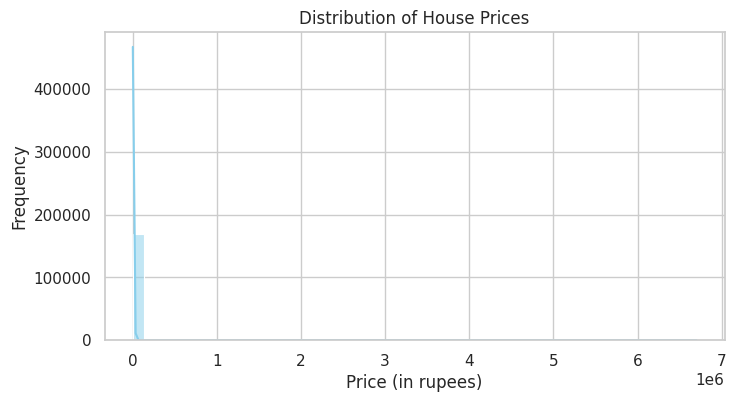

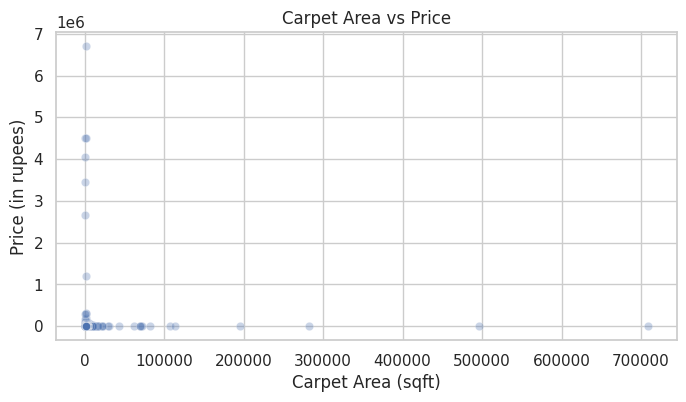

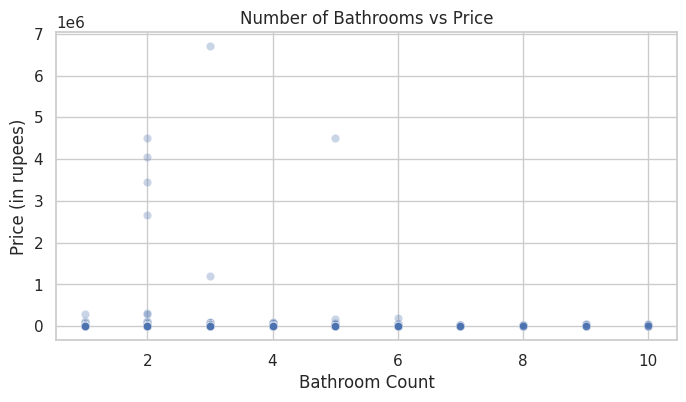

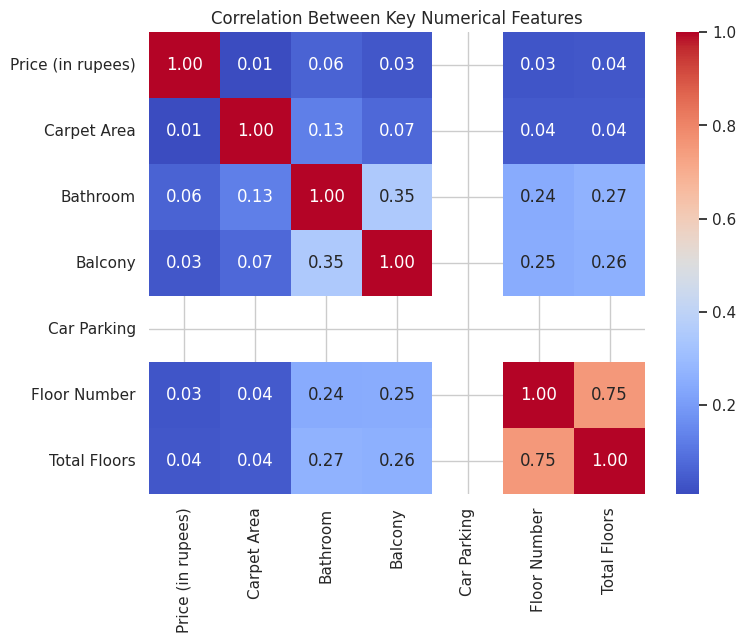

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set global style
sns.set(style="whitegrid")

# 1. Price distribution
plt.figure(figsize=(8, 4))
sns.histplot(df_clean["Price (in rupees)"], bins=50, kde=True, color='skyblue')
plt.title("Distribution of House Prices")
plt.xlabel("Price (in rupees)")
plt.ylabel("Frequency")
plt.show()

# 2. Carpet Area vs Price
plt.figure(figsize=(8, 4))
sns.scatterplot(x="Carpet Area", y="Price (in rupees)", data=df_clean, alpha=0.3)
plt.title("Carpet Area vs Price")
plt.xlabel("Carpet Area (sqft)")
plt.ylabel("Price (in rupees)")
plt.show()

# 3. Bathroom Count vs Price
plt.figure(figsize=(8, 4))
sns.scatterplot(x="Bathroom", y="Price (in rupees)", data=df_clean, alpha=0.3)
plt.title("Number of Bathrooms vs Price")
plt.xlabel("Bathroom Count")
plt.ylabel("Price (in rupees)")
plt.show()

# 4. Correlation heatmap (numeric only, selected features)
numeric_cols = ["Price (in rupees)", "Carpet Area", "Bathroom", "Balcony", "Car Parking", "Floor Number", "Total Floors"]
plt.figure(figsize=(8, 6))
sns.heatmap(df_clean[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Key Numerical Features")
plt.show()




##Step 4: Model Development

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge

# Prepare X and y
X = df_clean.drop(columns=["Title", "Price (in rupees)"], errors='ignore')
y = df_clean["Price (in rupees)"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X.fillna(0), y, test_size=0.2, random_state=42)

# Linear Regression
lr_model = LinearRegression().fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

# Ridge Regression
ridge_model = Ridge(alpha=1.0).fit(X_train, y_train)
ridge_preds = ridge_model.predict(X_test)


##Step 5: Model Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(name, y_true, y_pred):
    print(f"{name} Results:")
    print(f"  MAE  = {mean_absolute_error(y_true, y_pred):,.2f}")
    print(f"  MSE  = {mean_squared_error(y_true, y_pred):,.2f}")
    print(f"  RMSE = {np.sqrt(mean_squared_error(y_true, y_pred)):,.2f}\n")

evaluate_model("Linear Regression", y_test, lr_preds)
evaluate_model("Ridge Regression", y_test, ridge_preds)


Linear Regression Results:
  MAE  = 2,676.95
  MSE  = 1,969,883,225.67
  RMSE = 44,383.37

Ridge Regression Results:
  MAE  = 2,676.72
  MSE  = 1,969,724,378.85
  RMSE = 44,381.58

